In [144]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import torch

from utils import *
from fancyimpute import SimpleFill, KNN, SoftImpute, IterativeSVD, MatrixFactorization, NuclearNormMinimization, BiScaler
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
np.random.seed(0)

In [5]:
# Function produce_NA for generating missing values ------------------------------------------------------

def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=None, q=None):
    """
    Generate missing values for specifics missing-data mechanism and proportion of missing values. 
    
    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.
    p_miss : float
        Proportion of missing values to generate for variables which will have missing values.
    mecha : str, 
            Indicates the missing-data mechanism to be used. "MCAR" by default, "MAR", "MNAR" or "MNARsmask"
    opt: str, 
         For mecha = "MNAR", it indicates how the missing-data mechanism is generated: using a logistic regression ("logistic"), quantile censorship ("quantile") or logistic regression for generating a self-masked MNAR mechanism ("selfmasked").
    p_obs : float
            If mecha = "MAR", or mecha = "MNAR" with opt = "logistic" or "quanti", proportion of variables with *no* missing values that will be used for the logistic masking model.
    q : float
        If mecha = "MNAR" and opt = "quanti", quantile level at which the cuts should occur.
    
    Returns
    ----------
    A dictionnary containing:
    'X_init': the initial data matrix.
    'X_incomp': the data with the generated missing values.
    'mask': a matrix indexing the generated missing values.s
    """
    
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(X, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(X, p_miss).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

# EDA

In [6]:
data = pd.read_csv('trainSet.txt')

In [8]:
# N full rows
len(data.dropna())

6

In [9]:
# Percentage of missigness
round(data.isna().sum()/len(data), 2)

PatientID                0.00
ImageFile                0.00
Hospital                 0.00
Age                      0.00
Sex                      0.00
Temp_C                   0.18
Cough                    0.01
DifficultyInBreathing    0.00
WBC                      0.01
CRP                      0.04
Fibrinogen               0.68
LDH                      0.16
Ddimer                   0.72
Ox_percentage            0.28
PaO2                     0.20
SaO2                     0.68
pH                       0.24
CardiovascularDisease    0.02
RespiratoryFailure       0.18
Prognosis                0.00
dtype: float64

<AxesSubplot:>

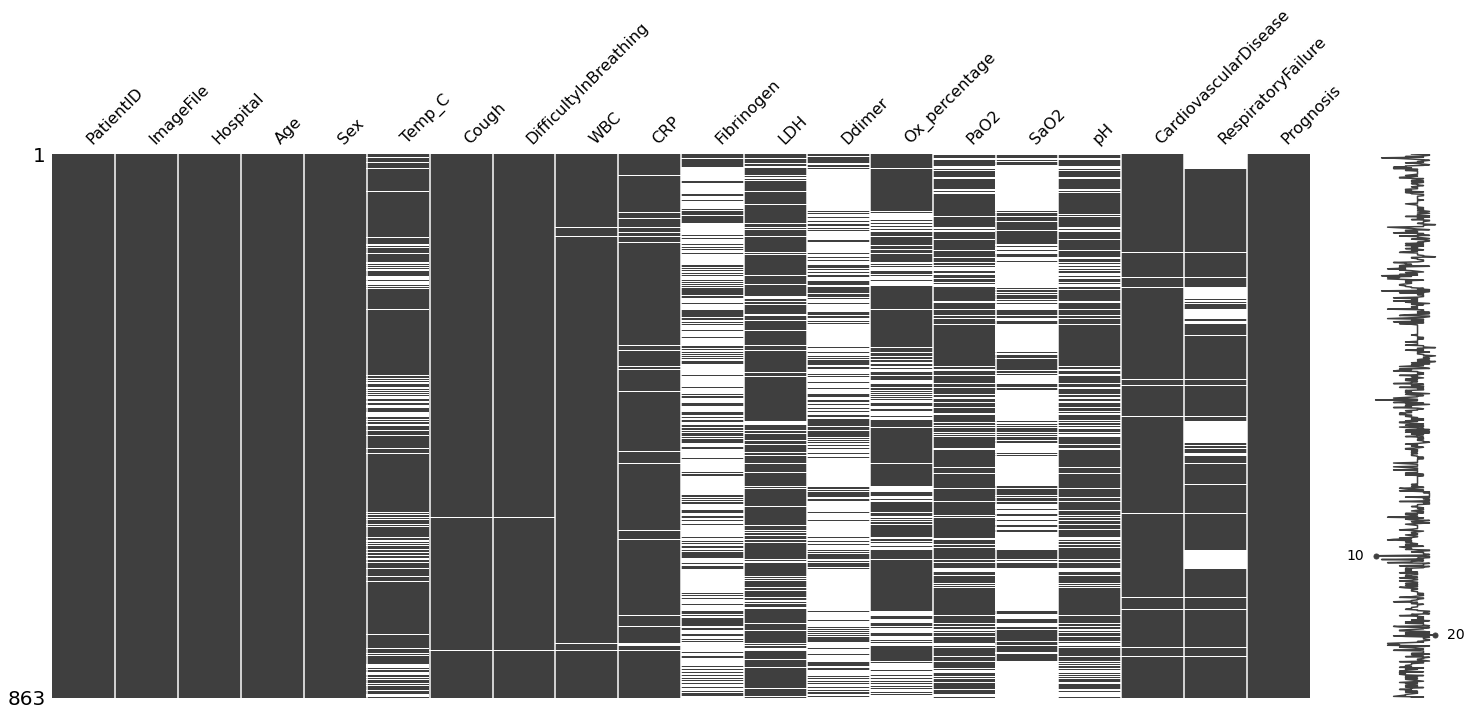

In [116]:
msno.matrix(data)

In [68]:
def preprocess(df):
   dataDropped = df.drop(['Ddimer', 'SaO2', 'Fibrinogen', 'Prognosis', 'PatientID', 'ImageFile', 'Hospital'], axis = 1).dropna()
   # Binary variables (Hackathon description_26_04.pdf)
   dataDropped['Cough'] = pd.factorize(dataDropped['Cough'])[0]
   dataDropped['Sex'] = pd.factorize(dataDropped['Sex'])[0]
   dataDropped['DifficultyInBreathing'] = pd.factorize(dataDropped['DifficultyInBreathing'])[0]
   dataDropped['CardiovascularDisease'] = pd.factorize(dataDropped['CardiovascularDisease'])[0]
   dataDropped['RespiratoryFailure'] = pd.factorize(dataDropped['RespiratoryFailure'])[0]
   return dataDropped

def standardize(df):
    return ((df - df.mean())/df.std())

In [117]:
def generateMissingData(df, p_miss=0.3):
    processed = preprocess(df)
#     standardized = standardize(processed)
    res = produce_NA(processed.to_numpy(), p_miss=p_miss, mecha="MCAR")
    res['X_init'] = pd.DataFrame(res['X_init'].numpy())
    res['X_init'].columns = processed.columns
    res['X_incomp'] = pd.DataFrame(res['X_incomp'].numpy())
    res['X_incomp'].columns = processed.columns
    res['mask'] = pd.DataFrame(res['mask'].numpy())
    res['mask'].columns = processed.columns
    return res

In [141]:
def evaluate(data, algorithm):
    msk = np.random.rand(len(data)) < 0.8
    train = preprocess(data[msk])
    test = data[~msk]
    full_data, missed_data, _ = generateMissingData(test).items()
    algorithm.fit(train)
    restored_data = algorithm.transform(missed_data[1])
    return np.linalg.norm(restored_data-full_data[1], ord = 2)

## Main Benchmark

In [155]:
algorithms = {
    "SimpleFill": SimpleImputer(),
    "KNN-10": KNNImputer(n_neighbors=10),
    "KNN-20": KNNImputer(n_neighbors=20),
    "KNN-30": KNNImputer(n_neighbors=30),
    "KNN-50": KNNImputer(n_neighbors=50),
    "KNN-70": KNNImputer(n_neighbors=70),
#     "SoftImpute": SoftImpute(),
    "IterativeImputer": IterativeImputer(),
#     "IterativeSVD": IterativeSVD(),
#     "MatrixFactorization": MatrixFactorization(),
#     "BiScaler": BiScaler()
    
#     "NuclearNormMinimization": NuclearNormMinimization()
}

benchmarkResults = {algorithm: [] for algorithm in algorithms}

In [156]:
for algorithm in algorithms:
    print("Start with {}".format(algorithm))
    for k in range(100):
        benchmarkResults[algorithm].append(evaluate(data, algorithms[algorithm]))
    print("End with {}".format(algorithm))
        

Start with SimpleFill
End with SimpleFill
Start with KNN-10
End with KNN-10
Start with KNN-20
End with KNN-20
Start with KNN-30
End with KNN-30
Start with KNN-50
End with KNN-50
Start with KNN-70
End with KNN-70
Start with IterativeImputer
End with IterativeImputer


In [149]:
for algorithm in algorithms:
    print("Result for algorithm {}".format(algorithm))
    print("Mean: {}".format(np.mean(benchmarkResults[algorithm])))
    print("Median: {}".format(np.median(benchmarkResults[algorithm])))
    print('\n')


Result for algorithm SimpleFill
Mean: 869.6797206993559
Median: 690.2096040933949


Result for algorithm KNN-10
Mean: 913.8275605190028
Median: 717.0483288154983


Result for algorithm IterativeImputer
Mean: 934.3009875911858
Median: 669.3888268026196




## Plot

In [150]:
def plot(m):
    dfs = []
    for key in m:
        dfs.append(pd.DataFrame(np.reshape(np.array(m[key]), (-1, 1))).assign(Algorithm=key))
    cdf = pd.concat(dfs)
    mdf = pd.melt(cdf, id_vars=['Algorithm'])
    mdf.rename(columns={"value": "MSE"}, inplace=True)
    ax = sns.boxplot(x="Algorithm", y="MSE", data=mdf)  # RUN PLOT   
#     plt.savefig("result.jpg")
    plt.show()

    plt.clf()

    plt.close()  

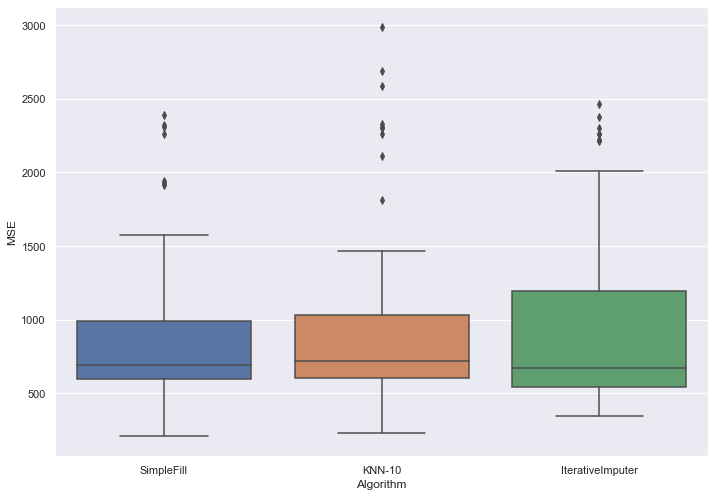

In [151]:
plot(benchmarkResults)

# Iterative Imputer with multiple regressors/estimators

In [153]:
iterativeImputers = {
    'BayesianRidge': IterativeImputer(random_state=0, estimator=BayesianRidge()),
    'DecisionTreeRegressor': IterativeImputer(random_state=0, estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0)),
    'ExtraTreesRegressor': IterativeImputer(random_state=0, estimator=ExtraTreesRegressor(n_estimators=10, random_state=0)),
#     'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=15)
}

iterativeBenchmarkResults = {iterativeImputer: [] for iterativeImputer in iterativeImputers}

for iterativeImputer in iterativeImputers:
    print("Start with {}".format(iterativeImputer))
    for k in range(100):
        iterativeBenchmarkResults[iterativeImputer].append(evaluate(data, iterativeImputers[iterativeImputer]))
    print("End with {}".format(iterativeImputer))


Start with BayesianRidge
End with BayesianRidge
Start with DecisionTreeRegressor
End with DecisionTreeRegressor
Start with ExtraTreesRegressor
End with ExtraTreesRegressor


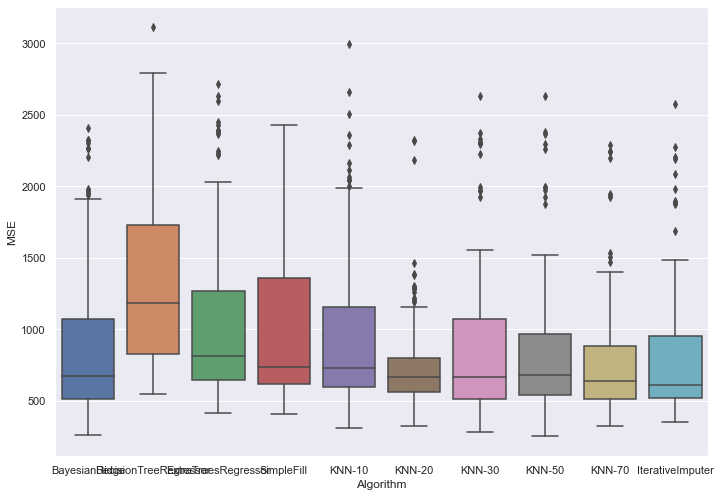

In [157]:
plot(dict(list(iterativeBenchmarkResults.items()) + list(benchmarkResults.items())))